In [2]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

urllib 패키지는 웹에서 데이터를 다운로드 받을 때 사용합니다

In [3]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)


(1920, 1080, 3)


# DeepLabModel

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

# 학습된 가중치 불러오기

In [7]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 받고 DeepLabModel 을 초기화합니다. 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다.

# 이미지 처리

In [8]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1920, 1080, 3) (513, 288, 3) 15


img_orig 의 크기는 1280x720 이고 img_resized 의 크기는 513x288 이 출력됐습니다. 입력 이미지 크기가 달라지면 resize 크기도 조금씩 달라지겠죠? (cv2는 채널을 HWC 순서로 표시한다는 점 잊지 마세요!)

세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻하는 seg_map.max() 는 20 이라는 값이 출력됩니다. 무슨 의미일까요?

위에서 말씀드린 것처럼 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다. 제공하는 라벨 종류는 아래와 같습니다.

In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 따라서 20 의 의미는 tv 가 되겠네요! 0부터 시작하니까요.

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 마스크를 만들고 시각화해 볼까요?

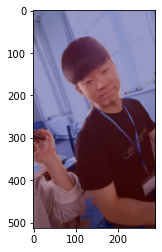

In [10]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

사람을 뜻하는 15 외 예측은 0으로 만들었습니다. 그럼 예측된 세그멘테이션 이미지(map)는 최대값이 15가 됩니다. 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다. applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력합니다.

# 이미지를 원래 크기로 복원

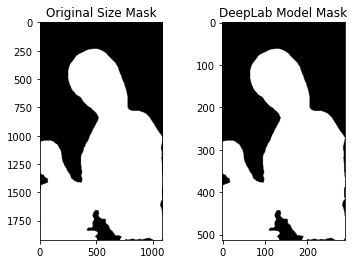

In [11]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

cv2.resize() 함수를 이용합니다. 크기를 키울 때 보간(interpolation) 을 고려해야 하는데요, cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용합니다. 여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법입니다.    
결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정합니다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.

# 배경 흐리게 하기

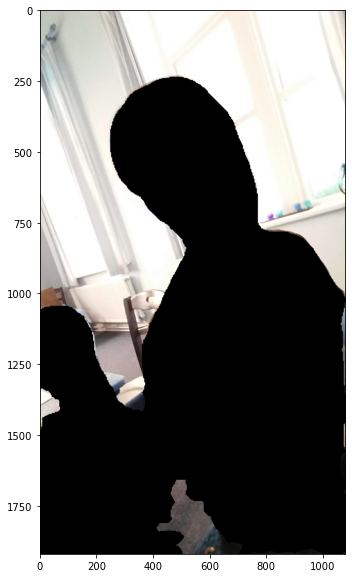

In [22]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.figure(figsize=(10,10))
plt.imshow(img_bg)
plt.show()

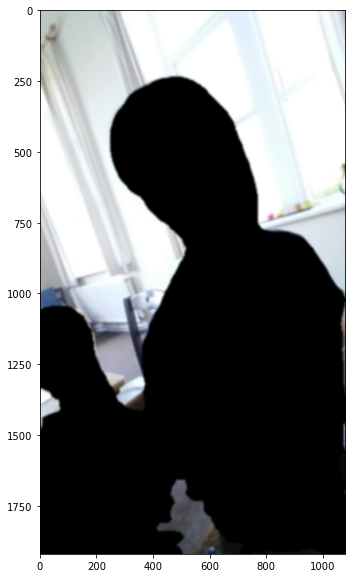

In [24]:
img_bg_blur = cv2.GaussianBlur(img_bg, (13,13),cv2.BORDER_DEFAULT)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 배경과 인물 합성

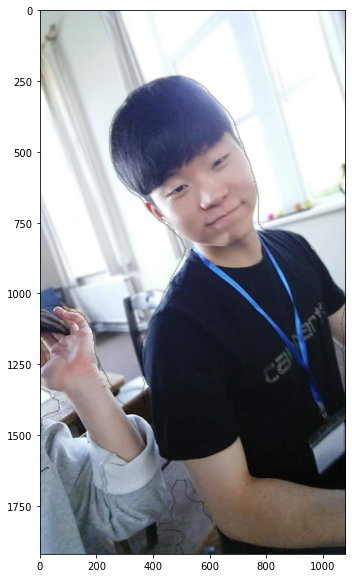

In [25]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

결과 이미지에서 볼 수 있듯 배경과 인물 segmentation이 완벽하게 이루어지지는 않았으나 좋은 분할을 보여주었다. 하지만 인물을 검은색 mask를 씌우고 blur처리시 경계면에서 그라데이션 효과가 나타나서 다시 인물을 씌웠을 때 약간의 검정 선을 볼 수 있다 (하얀 mask를 씌웠다면 하얀선이 나타났을 것). 그래서 이미지 blur처리 순서를 다음과 같이 바꾸었다: segmentation과 0,255 color 배정 -> 원본사진 전체 blur -> blur가 된 이미지에 인물 mask -> mask에 원본 인물 넣기.

### 이 과정을 하나의 함수로 만들어 줍니다.